In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score

In [2]:
!wget "https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv"

--2021-04-22 12:33:38--  https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5834924 (5.6M) [text/plain]
Saving to: ‘bank-additional-full.csv’

bank-additional-ful 100%[===================>]   5.56M  26.2MB/s    in 0.2s    

2021-04-22 12:33:39 (26.2 MB/s) - ‘bank-additional-full.csv’ saved [5834924/5834924]



**Data Set Information:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Output variable (desired target):
y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
data = pd.read_csv("/content/bank-additional-full.csv",sep=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [47]:
data.shape

(41188, 21)

In [4]:
data.info()
# The dataset has 20 columns(19 features, 1 response variable) and 41188 observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# list of all numerical features in the data
numerical_features = [column for column in data.columns if data[column].dtype!='object']
numerical_features

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [6]:
# list of all the categorical features in the data
categorical_features = [column for column in data.columns if (column!='y') and (data[column].dtype=='object')]
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [14]:
categories = [f"{column} : {data[column].unique()}" for column in categorical_features]
categories

["job : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'\n 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'\n 'student']",
 "marital : ['married' 'single' 'divorced' 'unknown']",
 "education : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'\n 'unknown' 'university.degree' 'illiterate']",
 "default : ['no' 'unknown' 'yes']",
 "housing : ['no' 'yes' 'unknown']",
 "loan : ['no' 'yes' 'unknown']",
 "contact : ['telephone' 'cellular']",
 "month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']",
 "day_of_week : ['mon' 'tue' 'wed' 'thu' 'fri']",
 "poutcome : ['nonexistent' 'failure' 'success']"]

**Data Preprocessing**<br>
- Use LabelEncoder to convert the label into numbers.<br>
- Perform one-hot encoding on the categorical features using df_dummies = pd.get_dummies(df)<br>
- Column "duration" must be deleted<br>
- Check if there are any missing values in the dataset. If there are, drop the rows.<br>
- Plot histogram of the label and calculate the imbalance in the dataset.<br>

In [7]:
# making a copy of original data
df = data.copy()
df.shape

(41188, 21)

In [8]:
# Encoding the labels using LabelEncoder
df[['y']] = df[['y']].apply(LabelEncoder().fit_transform)

In [9]:
df['y'].unique()

array([0, 1])

In [15]:
# Encoding categerical features to numerical using pandas get_dummies() method
df = pd.get_dummies(df, categorical_features)
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [16]:
df.shape

(41188, 64)

In [17]:
# deleting Column "duration" (duration: last contact duration, in seconds (numeric).This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
# Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.)
df.drop(columns="duration",inplace=True)
df.shape

(41188, 63)

In [18]:
# checking for the number of missing values in each column
df.isnull().sum()

age                     0
campaign                0
pdays                   0
previous                0
emp.var.rate            0
                       ..
day_of_week_tue         0
day_of_week_wed         0
poutcome_failure        0
poutcome_nonexistent    0
poutcome_success        0
Length: 63, dtype: int64

In [ ]:
# There are no missing values in any column

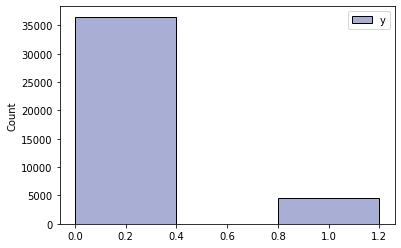

In [19]:
# Plot histogram of the label and calculate the imbalance in the dataset.
sns.histplot(df[['y']],binwidth=0.4,palette= 'BuPu')

In [24]:
#calculating the imbalance in the dataset
No  = df['y'].value_counts(normalize=True)[0]
yes =  df['y'].value_counts(normalize=True)[1]

print(" class No : %0.2f" % No)
print(" class Yes : %0.2f" % yes)

 class No : 0.89
 class Yes : 0.11


In [25]:
# This is a severely imbalanced dataset 89% of the data is in class 'No', whereas only 11% of data is in class 'yes'

**Let's model the data:**

In [26]:
# separate your dataset into a training and a test set, with a test size of 20% and random_state=50.
y = df['y']
X = df.drop(columns='y')
train_x, valid_x, train_y, valid_y = train_test_split(X,y,test_size=0.20, random_state=50,stratify=y)

print(f"Total number of Training samples: {train_x.shape[0]} \n Total number of test samples :  {valid_x.shape[0]}")

Total number of Training samples: 32950 
 Total number of test samples :  8238


In [ ]:
# Make sure the train/test split is stratified (and check that it is!)

In [29]:
train_y.value_counts(normalize=True)

0    0.887344
1    0.112656
Name: y, dtype: float64

In [30]:
valid_y.value_counts(normalize=True)

0    0.887351
1    0.112649
Name: y, dtype: float64

In [ ]:
# Both training and validation datasets have same percentage of class 0 and class 1 observations 

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

**RandomForestClassifier**

In [36]:
# Report the results of 10-fold stratified cross-validation on the training set using a random forest classifier with 100 trees and depth=3.
clf = RandomForestClassifier(n_estimators=100,max_depth=3,random_state=50)
scores = cross_val_score(clf,train_x,train_y,scoring='f1',cv=10)

print("f1: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))


f1: 0.25786987 +/- 0.04073029


**DummyClassifier**

In [32]:
dummy_clf = DummyClassifier(strategy="stratified") # always predicts the mean of the training set
dummy_scores = cross_val_score(dummy_clf, X, y, cv=10, scoring='f1')
print("f1: %0.8f +/- %0.8f" % (dummy_scores.mean(), dummy_scores.std()))

f1: 0.10869387 +/- 0.01297124


**Compare the results of your classifier with that of a dummy classifier**

**The dummyclassifier has low f1 score compared to RandomForestClassifier**

**GridSearchCV to find a better set of parameters for your random forest.**

In [ ]:
list(range(100,1000,100))

[100, 200, 300, 400, 500, 600, 700, 800, 900]

In [54]:
param_grid = {'n_estimators':range(100,600,100),
              'criterion':['gini','entropy'],
              'max_depth' : range(2,10,1)
              }

search = GridSearchCV(clf,
                      param_grid=param_grid,
                      scoring='f1',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10),
                      verbose=2)


In [55]:
search.fit(train_x,train_y)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 41.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

In [57]:
pred_y = search.predict(valid_x)


In [58]:
accuracy_score(valid_y,pred_y)

0.900825443068706

In [59]:
search.best_score_

0.3183603330890645

In [61]:
classifier = search.best_estimator_
classifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [62]:
classifier.fit(train_x,train_y)

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
features = X.columns
# Print the feature ranking
#print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

[ 7  8  2 61  4  6  5  0  3 52 43  1 49 59 60 50 42 44 55 31 53 10 48 56
 34 14 33 54 23 38 57 22 36 58 28 17  9 39 18 41 30 27 25 47 51 45 21 32
 16 13 15 19 26 46 12 20 37 40 11 24 29 35]
1. euribor3m (0.161577)
2. nr.employed (0.149672)
3. pdays (0.101237)
4. poutcome_success (0.081160)
5. emp.var.rate (0.076179)
6. cons.conf.idx (0.065292)
7. cons.price.idx (0.058479)
8. age (0.039460)
9. previous (0.024521)
10. month_oct (0.014689)
11. contact_telephone (0.013392)
12. campaign (0.013331)
13. month_mar (0.013238)
14. poutcome_failure (0.013006)
15. poutcome_nonexistent (0.012805)
16. month_may (0.012393)
17. contact_cellular (0.010390)
18. month_apr (0.007846)
19. day_of_week_mon (0.007432)
20. education_university.degree (0.005310)
21. month_sep (0.004704)
22. job_blue-collar (0.004665)
23. month_jun (0.004592)
24. day_of_week_thu (0.004463)
25. default_unknown (0.004378)
26. job_retired (0.004225)
27. default_no (0.004204)
28. day_of_week_fri (0.004185)
29. marital_single (0.0041

In [63]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


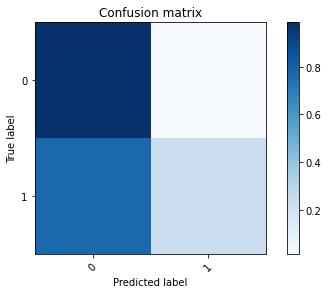

In [64]:
# Compute confusion matrix
import itertools
cnf_matrix = confusion_matrix(valid_y, pred_y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize=True,
                      title='Confusion matrix')

#plt.savefig("confusion.pdf", bbox_inches='tight')

In [72]:
# generalisation error (still using the same metric) on your test set.

In [71]:
pred_y = classifier.predict(valid_x)
acc_score = accuracy_score(valid_y,pred_y)
print(f"accuracy score : {acc_score}")
from sklearn.metrics import f1_score
f1 = f1_score(valid_y,pred_y)
print(f"f1_score on vaidation set after grid search : {f1}")

accuracy score : 0.900825443068706
f1_score on vaidation set after grid search : 0.34059725585149314


In [ ]:
# quiz

In [48]:
forest_clf = RandomForestClassifier(n_estimators=150,max_depth=6,random_state=50)
scores = cross_val_score(forest_clf,train_x,train_y,scoring='f1',cv=10)

print("f1: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))

f1: 0.28370588 +/- 0.04695821


In [49]:
forest_clf = RandomForestClassifier(n_estimators=200,max_depth=8,random_state=50)
scores = cross_val_score(forest_clf,train_x,train_y,scoring='f1',cv=10)

print(f"f1:{scores.mean()}")

f1:0.30009166356648936


In [50]:
forest_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=60)
scores = cross_val_score(forest_clf,train_x,train_y,scoring='f1',cv=10)

print(f"f1:{scores.mean()}")

f1:0.30309879535867823


In [51]:
forest_clf = RandomForestClassifier(n_estimators=300,max_depth=12,random_state=60)
forest_clf.fit(train_x,train_y)
imp = forest_clf.feature_importances_

In [53]:
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_],axis=0)
indices = np.argsort(imp)[::-1]
print(indices)
features = X.columns
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  imp[indices[f]]))

[ 7  8  2 61  4  0  6  5  1  3 59 60 52 49 43 50 42 55 31 38 36 56 54 23
 57 22 44 28 58  9 39 10 14 41 18 30 27 48 17 33 21 34 25 53 16 32 13 26
 19 15 51 45 47 12 37 40 11 20 46 24 29 35]
Feature ranking:
1. euribor3m (0.137780)
2. nr.employed (0.116927)
3. pdays (0.074017)
4. poutcome_success (0.069784)
5. emp.var.rate (0.061363)
6. age (0.060166)
7. cons.conf.idx (0.055543)
8. cons.price.idx (0.048979)
9. campaign (0.026308)
10. previous (0.025351)
11. poutcome_failure (0.016382)
12. poutcome_nonexistent (0.014782)
13. month_oct (0.013438)
14. month_mar (0.012811)
15. contact_telephone (0.012810)
16. month_may (0.012357)
17. contact_cellular (0.012290)
18. day_of_week_mon (0.010371)
19. education_university.degree (0.009047)
20. housing_yes (0.008521)
21. housing_no (0.008431)
22. day_of_week_thu (0.008164)
23. day_of_week_fri (0.007796)
24. marital_single (0.007611)
25. day_of_week_tue (0.007523)
26. marital_married (0.007450)
27. month_apr (0.007437)
28. education_high.school (0.